# Setup

In [144]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are not in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    filter_df, check_target_dependency, # EDA
    calculate_psi, # Validation
    train_lgbm, # Model Training
    clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    get_master_daily_target_data, generate_interday_target_features, 
    get_master_daily_price_data, generate_interday_price_features, 
    get_master_daily_volume_data, generate_interday_volume_features
)

In [145]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation, early_stopping
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [146]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
DATA_DIR = '../data/'

# Tree-Based Model Training

In [5]:
%%time
train = pd.read_parquet("../train_all.parquet")
train = train.drop(columns=get_cols(train, contains=["r1", "r2"]))

CPU times: user 14.6 s, sys: 22.6 s, total: 37.2 s
Wall time: 26.5 s


In [122]:
lgbm_best_params = {
    'boosting_type': 'gbdt', 
    'learning_rate': 0.02,
    'max_depth': 9,
    'n_estimators': 1200,
    'num_leaves': 400, # 416,
    'reg_alpha': 0.001,
    'reg_lambda': 0.001,
    'colsample_bytree': 0.6,
    'subsample': 0.55,
    'min_child_samples': 128
}

In [123]:
default_settings = dict(
    # objective='cross_entropy', 
    objective='mae', 
    histogram_pool_size=512, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=512, 
    n_jobs=-1, 
    verbose=-1
)

In [124]:
final_lgbm_params = default_settings | lgbm_best_params
print(final_lgbm_params)

{'objective': 'mae', 'histogram_pool_size': 512, 'force_col_wise': True, 'random_state': 1020, 'max_bin': 512, 'n_jobs': -1, 'verbose': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.02, 'max_depth': 9, 'n_estimators': 1200, 'num_leaves': 400, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'colsample_bytree': 0.6, 'subsample': 0.55, 'min_child_samples': 128}


In [125]:
%%time
# train = pd.read_parquet("../train_with_all_features.parquet")
# train = pl.read_parquet("../train_with_all_features.parquet")
# train = pd.read_parquet("../train_with_some_features.parquet")

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 15.3 µs


In [126]:
# train = train.drop(columns=get_cols(train, startswith="sc_", endswith=["size", "price", "flag"]))
# train = train.drop(columns=get_cols(train, startswith="sc_", endswith=("fod", "sod")))
# train = train.drop(columns=get_cols(train, contains="size", excludes=("log", "fod", "sod", "ratio", "diff")))
# train = train.drop(columns=get_cols(train, endswith=["l2", "l3", "l4"]))

In [127]:
FINAL_TARGET_COLUMN = "clipped_target"
cols_to_remove = ["date_id", "stock_id"]
add_list = []
# target_column_list = get_cols(train, "target", excludes=["ytd_", "normalized"])
# target_column_list

In [128]:
ab = pd.Series(train.columns)
target_column_list = ab[ab.str.contains("target") & ~ab.str.contains("|".join(["daily_", "normalized", "r0", "r1", "r2"]))].tolist()
target_column_list

['target', 'clipped_target', 'is_positive_target', 'is_mild_target']

In [129]:
train.shape

(5237980, 476)

In [130]:
train.head()

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,0,0,3180602.750,1,0.999812,13380277.0,NaN,NaN,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,10,1299772.750,1,1.000026,15261107.0,NaN,NaN,0.999812,...,-0.984148,1.834175e+06,-1.927485e+06,-0.951590,-1.927485e+06,1.834175e+06,-1.050873,-3761660.000,0.000,-inf
2,0,0,20,1299772.750,1,0.999919,15261107.0,NaN,NaN,0.999812,...,1.000000,-9.331000e+03,-9.331000e+03,1.000000,-9.331000e+03,-9.331000e+03,1.000000,0.000,0.000,NaN
3,0,0,30,1299772.750,1,1.000133,15261107.0,NaN,NaN,1.000026,...,1.000000,5.133250e+04,5.133250e+04,1.000000,5.133250e+04,5.133250e+04,1.000000,0.000,0.000,NaN
4,0,0,40,1218204.375,1,1.000455,15342675.0,NaN,NaN,1.000241,...,-1.632281,4.022632e+04,-1.229104e+05,-0.327282,-1.229100e+05,4.022595e+04,-3.055491,-163136.375,-0.375,4.350303e+05


In [131]:
feature_list = list_diff(train.columns.tolist(), target_column_list + cols_to_remove + add_list)
len(feature_list)

470

In [132]:
# %%time
# train = train.loc[:, train.columns[:550].tolist()]
# train.to_parquet("../train_with_some_features.parquet")

In [133]:
def objective(trial):
    va_score_list = []
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    for i in range(2, 4):
        cprint(f"{get_time_now()} Preparing Training Dataset...", color="green")
        train_data = get_lgbm_dataset(train, start_date=0, end_date=MINIMUM_TRAIN_DAYS + i * VAL_DAYS, feature_list=feature_list)
        # train_data = lgb.Dataset(
        #     tr.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), #.drop(columns=features_to_drop),
        #     tr["target"].values
        # )
        # del tr
        gc.collect()
        
        cprint(f"{get_time_now()} Preparing Validation Dataset...", color="green")
        valid_data = get_lgbm_dataset(train, start_date=MINIMUM_TRAIN_DAYS + i * VAL_DAYS + 1, end_date=MINIMUM_TRAIN_DAYS + (i + 1) * VAL_DAYS, feature_list=feature_list)
        
        # valid_data = lgb.Dataset(
        #     va.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), #.drop(columns=features_to_drop),
        #     va["target"].values,
        #     reference=train_data
        # )
        
        cprint(f"{get_time_now()} Suggesting hyparameters for this trial...", color="green")
        lgbm_trial_params = dict(
            boosting_type=trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
            learning_rate=trial.suggest_float("learning_rate", 0.02, 0.03), # 0.018052307589575444, 
            max_depth=trial.suggest_categorical("max_depth", [10, 11, 12, -1]), 
            n_estimators=trial.suggest_int("n_estimators", 400, 800, step=50),
            num_leaves=trial.suggest_int("num_leaves", 350, 450, step=25), 
            reg_alpha=trial.suggest_float("reg_alpha", 0.00001, 0.03, log=True), # 0.02216069565875271, 
            reg_lambda=trial.suggest_float("reg_lambda", 0.00001, 0.03, log=True), # 0.01223572246957101,
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 0.8),
            subsample=trial.suggest_float("subsample", 0.5, 0.95),
            min_child_samples=trial.suggest_int("min_child_samples", 32, 64, step=16),
            verbose=-1
        )
        final_lgbm_params = default_settings | lgbm_trial_params
        print(final_lgbm_params)
        
        cprint(f"{get_time_now()} Model Training...", color="green")
        model = lgb.train(
            params=final_lgbm_params,
            train_set=train_data, 
            valid_sets=[valid_data, train_data], 
            # feval=lgb_amex_metric, 
            # early_stopping_rounds=200,
            # categorical_feature=["stock_id"],
            callbacks=[
                log_evaluation(100),
            ]
        )
        del train_data, valid_data
        gc.collect()
        
        va = train.loc[train["date_id"].between(MINIMUM_TRAIN_DAYS + i * VAL_DAYS + 1, MINIMUM_TRAIN_DAYS + (i + 1) * VAL_DAYS)]
        va_pred = lgbm_inference_by_batch(model, va, verbose=0)
        va_score = (va_pred - va["target"]).abs().mean()
        
        va_pred_zero_sum = zero_sum(va_pred, va['bid_size'] + va['ask_size'])
        va_pred_zero_sum_score = (va_pred_zero_sum - va["target"]).abs().mean()
        
        cprint(f"{get_time_now()} Ori score: {va_score:.5f}, Zero sum score: {va_pred_zero_sum_score:.5f}", color="blue")
        va_score_list.append(va_pred_zero_sum_score)
        
    return np.mean(va_score_list)

In [45]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

In [46]:
# master_df.to_parquet(f"{DATA_DIR}/optiver-train-data/w18_features.parquet")

In [43]:
# psi_list = []
# for feature in get_cols(val, contains=["price", "val"]):
#     psi_ = calculate_psi(train[feature].clip(1e6, -1e6).dropna(), val[feature].clip(1e6, -1e6).dropna())
#     if psi_ > 0.2:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="red")
#     elif psi_ > 0.1:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="yellow")
#     else:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="blue")
#     psi_list.append(psi_)

In [ ]:
# psi_list2 = []
# for feature in feature_list:
#     psi_ = calculate_psi2(train[feature].clip(1e6, -1e6).dropna(), val[feature].clip(1e6, -1e6).dropna())
#     if psi_ > 0.2:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="red")
#     elif psi_ > 0.1:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="yellow")
#     else:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="blue")
#     psi_list2.append(psi_)

In [45]:
# feature_psi_df = pd.DataFrame(dict(feature=get_cols(val, contains=["price", "val"]), psi=psi_list))
# feature_psi_df.to_csv("../new_psi_df.csv", index=False)

In [46]:
# %%time
# train = pd.concat([train, val], ignore_index=True)
# del val
# gc.collect()
# check_memory_usage(color="blue")

In [134]:
VAL_DAYS = 60
MINIMUM_TRAIN_DAYS = 240
LAST_TRAIN_DATE = MINIMUM_TRAIN_DAYS + 3 * VAL_DAYS
LAST_TRAIN_DATE

420

In [136]:
default_settings = dict(
    # objective='cross_entropy', 
    objective='mae', 
    histogram_pool_size=512, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=512, 
    n_jobs=-1, 
    verbose=-1
)

In [94]:
%%time
model, valid_pred, best_score = train_lgbm(data=train, feature_list=final_features200, lgbm_params=final_lgbm_params)

10:41:34 Preparing Dataset...
10:41:58 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6.31847	training's mae: 6.31847	valid_0's l1: 5.70516	valid_0's mae: 5.70516
[200]	training's l1: 6.2719	training's mae: 6.2719	valid_0's l1: 5.69189	valid_0's mae: 5.69189
[300]	training's l1: 6.23934	training's mae: 6.23934	valid_0's l1: 5.68677	valid_0's mae: 5.68677
[400]	training's l1: 6.21163	training's mae: 6.21163	valid_0's l1: 5.68385	valid_0's mae: 5.68385
[500]	training's l1: 6.18422	training's mae: 6.18422	valid_0's l1: 5.68193	valid_0's mae: 5.68193
[600]	training's l1: 6.16001	training's mae: 6.16001	valid_0's l1: 5.68104	valid_0's mae: 5.68104
[700]	training's l1: 6.1365	training's mae: 6.1365	valid_0's l1: 5.68046	valid_0's mae: 5.68046
[800]	training's l1: 6.11202	training's mae: 6.11202	valid_0's l1: 5.67983	valid_0's mae: 5.67983
[900]	training's l1: 6.08864	training's mae: 6.08864	valid_0's l1: 5.67973	valid_0's mae: 5.67973
Early sto

In [139]:
lgbm_model = lgb.Booster(model_file=f"../models/lgbm/lgbm_model5_val.txt")
previous_feature_list = lgbm_model.feature_name()
feature_imp_df = plot_feature_importance(
    features=lgbm_model.feature_name(), importances=lgbm_model.feature_importance(), return_df=True, limit=50, figsize=(18, 11), plot_chart=False
)
final_features225 = feature_imp_df["feature"][:225].tolist()

In [140]:
%%time
model225, val_df225, best_score225 = train_lgbm(data=train, feature_list=final_features225, lgbm_params=final_lgbm_params)

12:20:56 Preparing Dataset...
12:21:19 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6.3173	training's mae: 6.3173	valid_0's l1: 5.71039	valid_0's mae: 5.71039
[200]	training's l1: 6.27073	training's mae: 6.27073	valid_0's l1: 5.69734	valid_0's mae: 5.69734
[300]	training's l1: 6.23899	training's mae: 6.23899	valid_0's l1: 5.69213	valid_0's mae: 5.69213
[400]	training's l1: 6.21335	training's mae: 6.21335	valid_0's l1: 5.68976	valid_0's mae: 5.68976
[500]	training's l1: 6.18549	training's mae: 6.18549	valid_0's l1: 5.68784	valid_0's mae: 5.68784
[600]	training's l1: 6.16095	training's mae: 6.16095	valid_0's l1: 5.6868	valid_0's mae: 5.6868
[700]	training's l1: 6.13734	training's mae: 6.13734	valid_0's l1: 5.68625	valid_0's mae: 5.68625
[800]	training's l1: 6.11567	training's mae: 6.11567	valid_0's l1: 5.68575	valid_0's mae: 5.68575
[900]	training's l1: 6.09561	training's mae: 6.09561	valid_0's l1: 5.68556	valid_0's mae: 5.68556
[1000]	tr

In [114]:
val_df225["final_pred"] = (val_df250.reset_index(drop=True)["val_pred"] + val_df225["val_pred"]) / 2

In [116]:
val_df225 = val_df225.merge(train[META_COLUMNS + ["target"]], on=META_COLUMNS, how="left")

In [121]:
(val_df225["final_pred"] - val_df225["target"]).abs().mean()

5.684105408873237

11:49:25 Preparing Dataset...
11:49:46 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6.3173	training's mae: 6.3173	valid_0's l1: 5.70398	valid_0's mae: 5.70398
[200]	training's l1: 6.27073	training's mae: 6.27073	valid_0's l1: 5.69094	valid_0's mae: 5.69094
[300]	training's l1: 6.23899	training's mae: 6.23899	valid_0's l1: 5.68572	valid_0's mae: 5.68572
[400]	training's l1: 6.21335	training's mae: 6.21335	valid_0's l1: 5.68335	valid_0's mae: 5.68335
[500]	training's l1: 6.18549	training's mae: 6.18549	valid_0's l1: 5.68144	valid_0's mae: 5.68144
[600]	training's l1: 6.16095	training's mae: 6.16095	valid_0's l1: 5.6804	valid_0's mae: 5.6804
[700]	training's l1: 6.13734	training's mae: 6.13734	valid_0's l1: 5.67985	valid_0's mae: 5.67985
[800]	training's l1: 6.11567	training's mae: 6.11567	valid_0's l1: 5.67934	valid_0's mae: 5.67934
[900]	training's l1: 6.09561	training's mae: 6.09561	valid_0's l1: 5.67915	valid_0's mae: 5.67915
[1000]	tr

11:27:19 Preparing Dataset...
11:27:41 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6.31581	training's mae: 6.31581	valid_0's l1: 5.70337	valid_0's mae: 5.70337
[200]	training's l1: 6.26898	training's mae: 6.26898	valid_0's l1: 5.69001	valid_0's mae: 5.69001
[300]	training's l1: 6.23564	training's mae: 6.23564	valid_0's l1: 5.68441	valid_0's mae: 5.68441
[400]	training's l1: 6.2094	training's mae: 6.2094	valid_0's l1: 5.68188	valid_0's mae: 5.68188
[500]	training's l1: 6.18403	training's mae: 6.18403	valid_0's l1: 5.68037	valid_0's mae: 5.68037
[600]	training's l1: 6.16021	training's mae: 6.16021	valid_0's l1: 5.67966	valid_0's mae: 5.67966
[700]	training's l1: 6.13659	training's mae: 6.13659	valid_0's l1: 5.67918	valid_0's mae: 5.67918
Early stopping, best iteration is:
[672]	training's l1: 6.14318	training's mae: 6.14318	valid_0's l1: 5.67921	valid_0's mae: 5.67921
Evaluated only: l1
11:42:24 Getting Validation Prediction...
CPU times

In [48]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=LAST_TRAIN_DATE, feature_list=feature_list) 
    valid_data = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    # model.save_model(f'../models/lgbm/lgbm_model5_val.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

09:46:13 Preparing Dataset...
09:46:24 Training...
[100]	training's l1: 6.32486	valid_0's l1: 5.71157
[200]	training's l1: 6.27829	valid_0's l1: 5.69829
[300]	training's l1: 6.24572	valid_0's l1: 5.69318
[400]	training's l1: 6.21802	valid_0's l1: 5.69025
[500]	training's l1: 6.19061	valid_0's l1: 5.68834
[600]	training's l1: 6.1664	valid_0's l1: 5.68744
[700]	training's l1: 6.14289	valid_0's l1: 5.68686
[800]	training's l1: 6.1184	valid_0's l1: 5.68623
[900]	training's l1: 6.09503	valid_0's l1: 5.68614
[1000]	training's l1: 6.07398	valid_0's l1: 5.68627
[1100]	training's l1: 6.05369	valid_0's l1: 5.68648
[1200]	training's l1: 6.03289	valid_0's l1: 5.68698
CPU times: user 2h 5min 18s, sys: 7min 37s, total: 2h 12min 55s
Wall time: 15min 22s


In [91]:
len(model.feature_name())

200

In [22]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=LAST_TRAIN_DATE, feature_list=feature_list) 
    valid_data = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    # model.save_model(f'../models/lgbm/lgbm_model5_val.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

01:55:20 Preparing Dataset...
01:55:45 Training...
[100]	training's l1: 6.32461	valid_0's l1: 5.7121
[200]	training's l1: 6.27697	valid_0's l1: 5.69825
[300]	training's l1: 6.24298	valid_0's l1: 5.69321
[400]	training's l1: 6.21764	valid_0's l1: 5.69035
[500]	training's l1: 6.19442	valid_0's l1: 5.68854
[600]	training's l1: 6.17227	valid_0's l1: 5.68737
[700]	training's l1: 6.1518	valid_0's l1: 5.68628
[800]	training's l1: 6.13177	valid_0's l1: 5.68531
[900]	training's l1: 6.11224	valid_0's l1: 5.68527
[1000]	training's l1: 6.0984	valid_0's l1: 5.68513
[1100]	training's l1: 6.08181	valid_0's l1: 5.68512
[1200]	training's l1: 6.06823	valid_0's l1: 5.68503
CPU times: user 2h 43min 32s, sys: 9min 16s, total: 2h 52min 49s
Wall time: 23min 55s


01:18:30 Preparing Dataset...
01:18:59 Training...
[100]	training's l1: 6.32388	valid_0's l1: 5.71131
[200]	training's l1: 6.27437	valid_0's l1: 5.69678
[300]	training's l1: 6.24215	valid_0's l1: 5.69165
[400]	training's l1: 6.21604	valid_0's l1: 5.6887
[500]	training's l1: 6.19152	valid_0's l1: 5.68685
[600]	training's l1: 6.16739	valid_0's l1: 5.6855
[700]	training's l1: 6.14625	valid_0's l1: 5.68455
[800]	training's l1: 6.12665	valid_0's l1: 5.68379
[900]	training's l1: 6.10612	valid_0's l1: 5.68346
[1000]	training's l1: 6.08629	valid_0's l1: 5.68321
[1100]	training's l1: 6.06654	valid_0's l1: 5.68324
[1200]	training's l1: 6.05011	valid_0's l1: 5.68326
[1300]	training's l1: 6.03146	valid_0's l1: 5.68331
CPU times: user 3h 24min 21s, sys: 10min 52s, total: 3h 35min 14s
Wall time: 26min 25s


In [64]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=LAST_TRAIN_DATE, feature_list=feature_list) 
    valid_data = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    model.save_model(f'../models/lgbm/lgbm_model5_val.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

06:36:18 Preparing Dataset...
06:36:52 Training...
[100]	training's l1: 6.32345	valid_0's l1: 5.71087
[200]	training's l1: 6.27765	valid_0's l1: 5.69522
[300]	training's l1: 6.24863	valid_0's l1: 5.68875
[400]	training's l1: 6.22741	valid_0's l1: 5.68541
[500]	training's l1: 6.20724	valid_0's l1: 5.68322
[600]	training's l1: 6.18952	valid_0's l1: 5.68185
[700]	training's l1: 6.17353	valid_0's l1: 5.681
[800]	training's l1: 6.15843	valid_0's l1: 5.68032
[900]	training's l1: 6.14514	valid_0's l1: 5.67987
[1000]	training's l1: 6.13234	valid_0's l1: 5.67947
[1100]	training's l1: 6.1198	valid_0's l1: 5.67914
[1200]	training's l1: 6.10817	valid_0's l1: 5.67905
[1300]	training's l1: 6.09692	valid_0's l1: 5.67904
CPU times: user 2h 34min 12s, sys: 8min 30s, total: 2h 42min 43s
Wall time: 20min 22s


05:02:18 Preparing Dataset...
05:03:02 Training...
[100]	training's l1: 6.31957	valid_0's l1: 5.70981
[200]	training's l1: 6.26869	valid_0's l1: 5.69277
[300]	training's l1: 6.23721	valid_0's l1: 5.68607
[400]	training's l1: 6.21397	valid_0's l1: 5.68235
[500]	training's l1: 6.19345	valid_0's l1: 5.68014
[600]	training's l1: 6.17301	valid_0's l1: 5.67832
[700]	training's l1: 6.15654	valid_0's l1: 5.67735
[800]	training's l1: 6.14008	valid_0's l1: 5.67648
[900]	training's l1: 6.12393	valid_0's l1: 5.67582
[1000]	training's l1: 6.10993	valid_0's l1: 5.67545
[1100]	training's l1: 6.09713	valid_0's l1: 5.6753
[1200]	training's l1: 6.08449	valid_0's l1: 5.67513
[1300]	training's l1: 6.0716	valid_0's l1: 5.67477
CPU times: user 2h 38min 31s, sys: 8min 13s, total: 2h 46min 44s
Wall time: 20min 48s


In [65]:
del model, valid_data
gc.collect()
check_memory_usage(color="blue")

RAM used: 2.1 GB


2.13665771484375

In [66]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=480, feature_list=feature_list) 
    valid_data2 = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model2 = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data2, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    model2.save_model(f'../models/lgbm/lgbm_model5.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

06:56:41 Preparing Dataset...
06:57:25 Training...
[100]	training's l1: 6.24647	valid_0's l1: 5.68872
[200]	training's l1: 6.20406	valid_0's l1: 5.65156
[300]	training's l1: 6.17774	valid_0's l1: 5.62807
[400]	training's l1: 6.15683	valid_0's l1: 5.60854
[500]	training's l1: 6.13987	valid_0's l1: 5.59275
[600]	training's l1: 6.12396	valid_0's l1: 5.5778
[700]	training's l1: 6.10948	valid_0's l1: 5.56406
[800]	training's l1: 6.097	valid_0's l1: 5.55228
[900]	training's l1: 6.08447	valid_0's l1: 5.54061
[1000]	training's l1: 6.07194	valid_0's l1: 5.52888
[1100]	training's l1: 6.05975	valid_0's l1: 5.51761
[1200]	training's l1: 6.04838	valid_0's l1: 5.50678
[1300]	training's l1: 6.03918	valid_0's l1: 5.49847
CPU times: user 2h 55min 5s, sys: 8min 41s, total: 3h 3min 46s
Wall time: 23min 46s


In [67]:
val = valid_data2.get_data()

In [40]:
train[["stock_id", "date_id", "seconds", "imb_size", "imb_size_cumavg"]]

,stock_id,date_id,seconds,imb_size,imb_size_cumavg
0,0,0,0,3180602.750,NaN
1,0,0,10,1299772.750,-940415.000000
2,0,0,20,1299772.750,-626943.312500
3,0,0,30,1299772.750,-470207.500000
4,0,0,40,1218204.375,-392479.687500
...,...,...,...,...,...
5237975,199,480,500,-2661783.500,111221.960938
5237976,199,480,510,-2658917.500,109138.195312
5237977,199,480,520,-1352558.875,131727.250000
5237978,199,480,530,-1352558.875,129287.859375


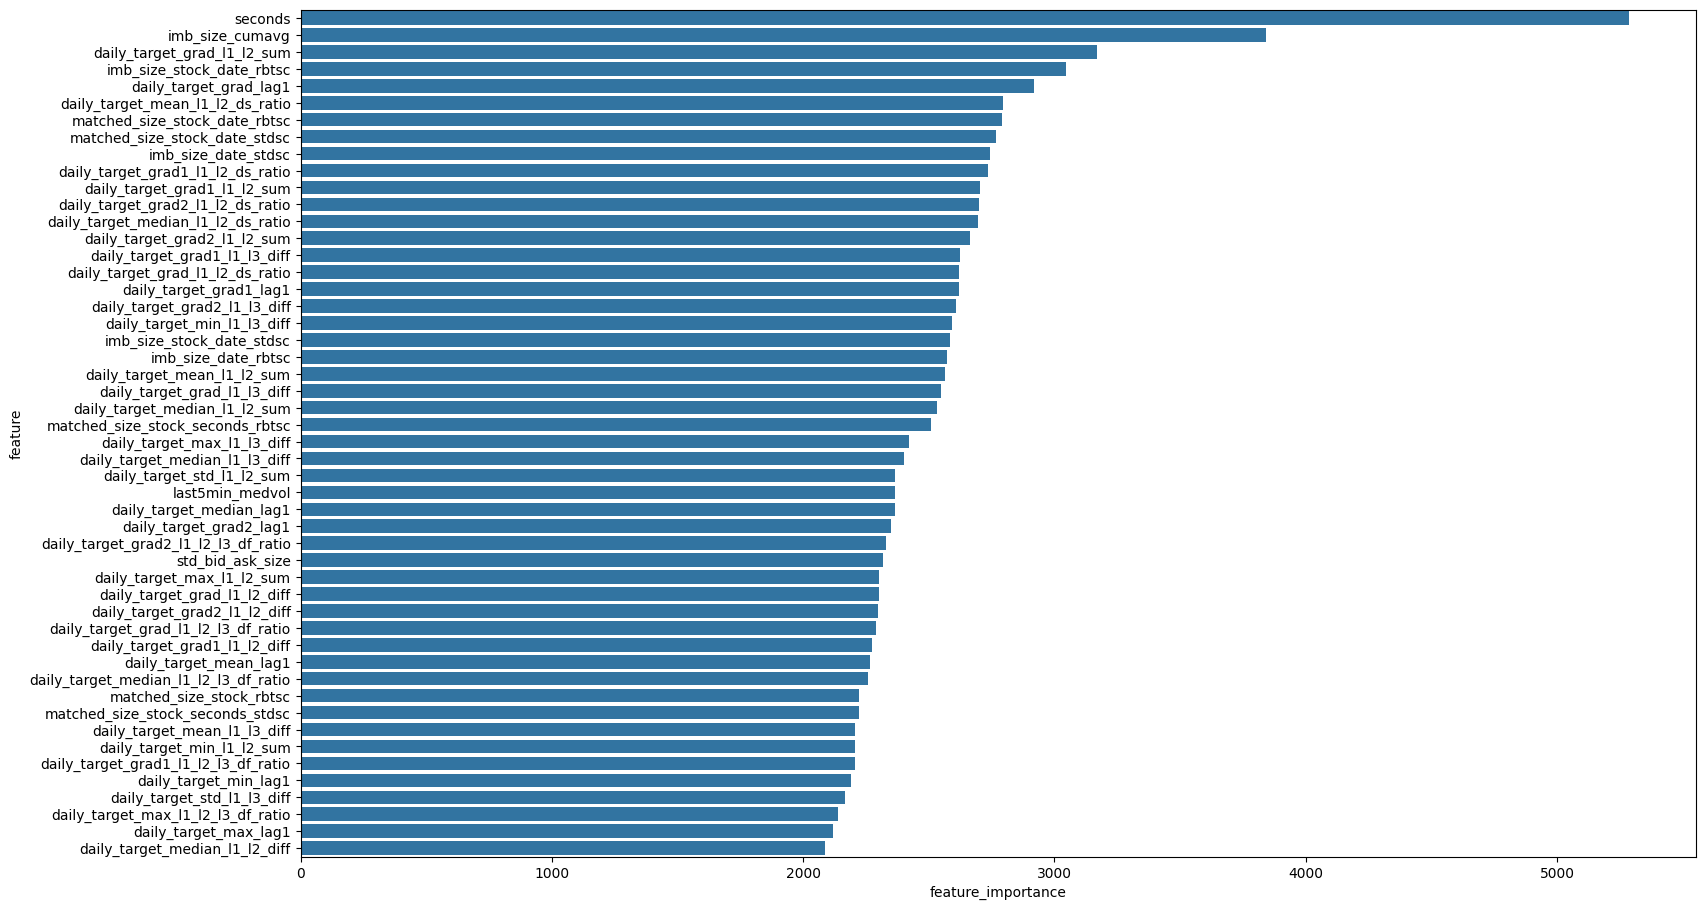

In [95]:
lgbm_model = lgb.Booster(model_file=f"../models/lgbm/lgbm_model5_val.txt")
previous_feature_list = lgbm_model.feature_name()
feature_imp_df = plot_feature_importance(
    features=lgbm_model.feature_name(), importances=lgbm_model.feature_importance(), return_df=True, limit=50, figsize=(18, 11)
)

In [55]:
feature_imp_df.loc[feature_imp_df["feature"].str.contains("e_l1_ratio")]

,feature,feature_importance,feature_importance_rank
167,imb_size_l1_ratio,845,160
237,matched_size_l1_ratio,573,223
340,ask_price_l1_ratio,348,299
385,wa_price_l1_ratio,281,331
391,ref_price_l1_ratio,273,336
393,bid_price_l1_ratio,269,338
396,ask_size_l1_ratio,263,341
399,bid_size_l1_ratio,253,343
459,near_price_l1_ratio,97,395
464,far_price_l1_ratio,63,400


In [56]:
feature_imp_df.loc[feature_imp_df["feature"].str.contains("c_l2_ratio")]

,feature,feature_importance,feature_importance_rank
264,wa_price_sc_l2_ratio,507,241
316,bid_price_sc_l2_ratio,400,279
319,ask_price_sc_l2_ratio,397,281
366,ref_price_sc_l2_ratio,322,313
395,near_price_sc_l2_ratio,266,340
435,far_price_sc_l2_ratio,166,374


In [59]:
feature_imp_df.tail(50)

,feature,feature_importance,feature_importance_rank
420,far_ref_fod_spread,200,361
421,bid_size,194,362
422,far_price_sod,193,363
423,bid_price_l1_l2_ratio_diff,192,364
424,far_wa_sc_ratio,191,365
425,near_ref_fod_spread,190,366
426,far_bid_sp_ratio,188,367
427,ask_far_fod_ratio,183,368
428,far_wa_fod_sum,182,369
429,near_ref_fod_ratio,182,369


In [53]:
feature_imp_df.loc[feature_imp_df["feature"].str.contains("e_l2_ratio")]

,feature,feature_importance,feature_importance_rank
131,imb_size_l2_ratio,1040,127
218,matched_size_l2_ratio,616,207
254,wa_price_l2_ratio,526,234
325,ref_price_l2_ratio,380,287
327,bid_price_l2_ratio,376,289
328,bid_size_l2_ratio,371,290
330,ask_price_l2_ratio,370,291
334,ask_size_l2_ratio,358,295
413,near_price_l2_ratio,227,355
431,far_price_l2_ratio,178,371


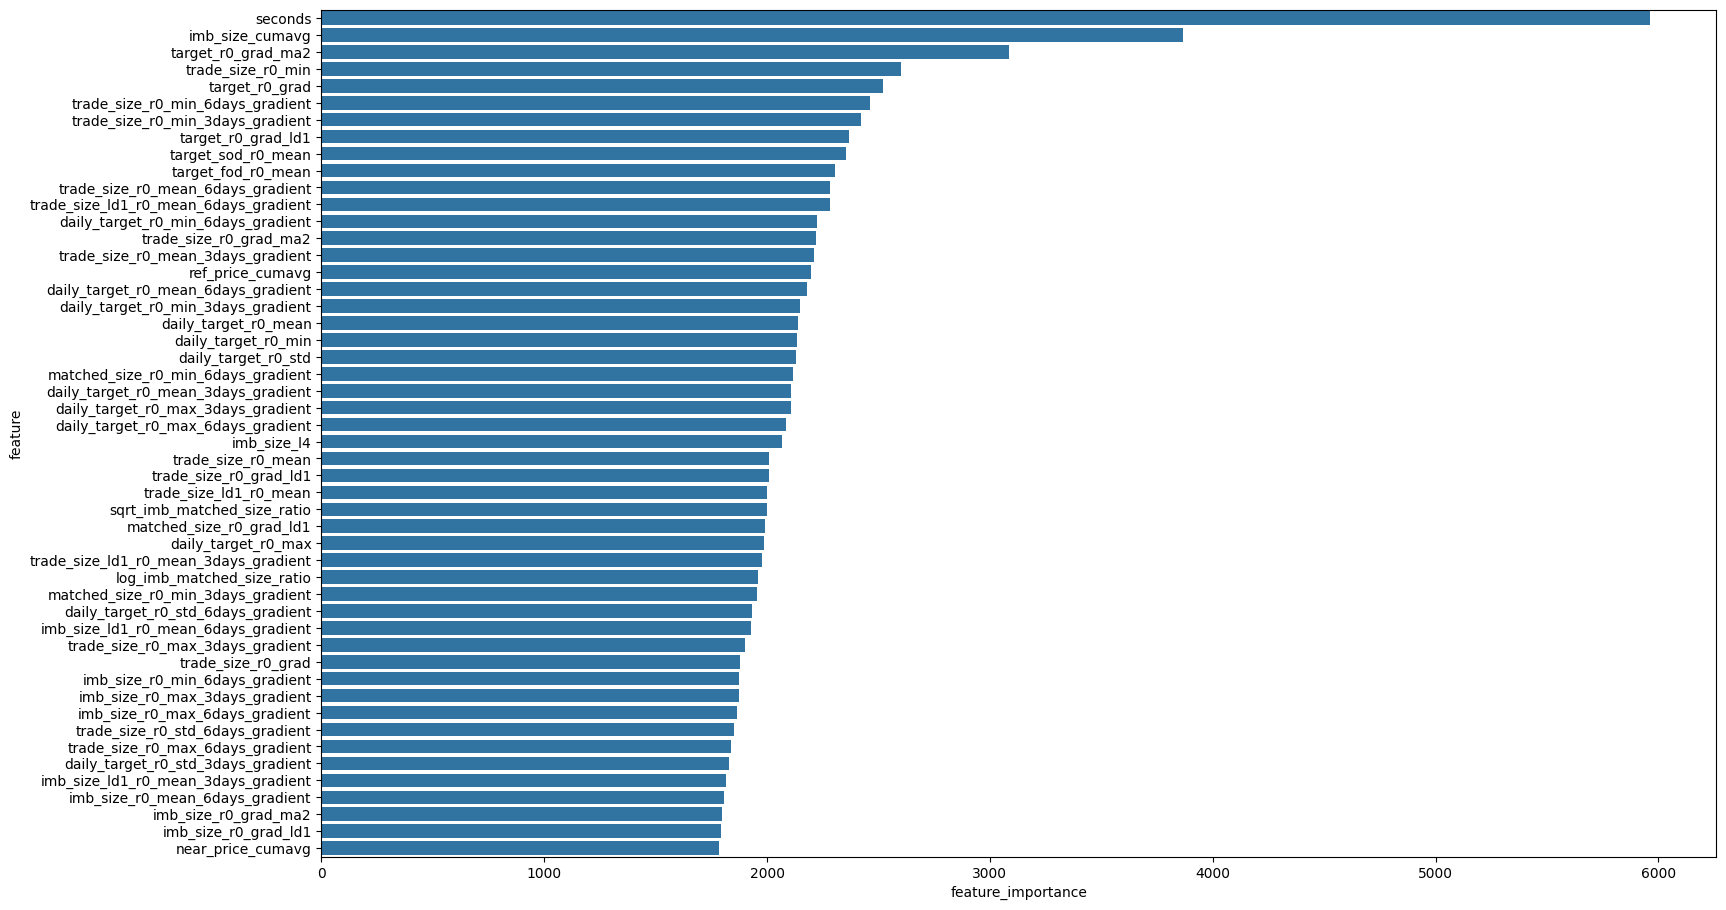

In [68]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=480, feature_list=feature_list) 
    valid_data2 = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model2 = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data2, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    model2.save_model(f'../models/lgbm/lgbm_model5.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

00:55:54 Preparing Dataset...
00:56:40 Training...
[100]	training's l1: 6.24388	valid_0's l1: 5.69764
[200]	training's l1: 6.1973	valid_0's l1: 5.66798
[300]	training's l1: 6.1675	valid_0's l1: 5.6506
[400]	training's l1: 6.14535	valid_0's l1: 5.63712
[500]	training's l1: 6.1265	valid_0's l1: 5.62635
[600]	training's l1: 6.10942	valid_0's l1: 5.61723
[700]	training's l1: 6.09367	valid_0's l1: 5.60957
[800]	training's l1: 6.0806	valid_0's l1: 5.60283
[900]	training's l1: 6.06681	valid_0's l1: 5.5965
[1000]	training's l1: 6.05406	valid_0's l1: 5.58979
[1100]	training's l1: 6.04142	valid_0's l1: 5.58329
[1200]	training's l1: 6.02983	valid_0's l1: 5.57823
CPU times: user 2h 50min 41s, sys: 8min 31s, total: 2h 59min 13s
Wall time: 22min 26s


In [ ]:
params = dict(
    iterations=trial.suggest_int("iterations", 100, 500),
    learning_rate=trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
    depth=trial.suggest_int("depth", 3, 9),
    subsample=trial.suggest_float("subsample", 0.35, 0.95),
    colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 0.9),
    min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 5),
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0, 1),
    grow_policy=trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
    random_strength=trial.suggest_float("random_strength", 0, 1),
    verbose=0,
)
model = CatBoostClassifier(**params)
X_tr = X_train.iloc[tr_idx]
y_tr = y_train[tr_idx]
X_va = X_train.iloc[va_idx]
y_va = y_train[va_idx]
model.fit(X_tr, y_tr)

In [57]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=LAST_TRAIN_DATE, feature_list=feature_list)
    # tr = train.filter(
    #     pl.col("date_id").is_between(0, LAST_TRAIN_DATE),
    # )
    # tr = train.loc[train["date_id"].between(0, 480)]
    # cprint(f"Train shape {tr.shape}", color="yellow")
    # train_data = lgb.Dataset(
    #     tr.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), 
    #     tr["target"] # tr["target"].values
    # )
    # del tr
    gc.collect()
    
    # va = train.loc[train["date_id"].between(LAST_TRAIN_DATE + 1, 480)]
    # va = train.filter(
    #     pl.col("date_id").is_between(LAST_TRAIN_DATE + 1, 480),
    # )
    # valid_data = lgb.Dataset(
    #     va.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"),
    #     va["target"], # va["target"].values,
    #     reference=train_data
    # )
    valid_data = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list)
    # del train
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data, valid_data
    gc.collect()
    
    # model_list.append(model)
    model.save_model(f'../models/lgbm/lgbm_model4.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

22:28:23 Preparing Dataset...
22:28:39 Training...
[100]	training's l1: 6.33021	valid_0's l1: 5.71322
[200]	training's l1: 6.28927	valid_0's l1: 5.69833
[300]	training's l1: 6.26369	valid_0's l1: 5.69304
[400]	training's l1: 6.24406	valid_0's l1: 5.6906
[500]	training's l1: 6.22658	valid_0's l1: 5.68908
[600]	training's l1: 6.20932	valid_0's l1: 5.68752
[700]	training's l1: 6.19515	valid_0's l1: 5.68643
[800]	training's l1: 6.18268	valid_0's l1: 5.68568
[900]	training's l1: 6.16862	valid_0's l1: 5.68515
[1000]	training's l1: 6.15748	valid_0's l1: 5.68503
CPU times: user 1h 27min 12s, sys: 3min 38s, total: 1h 30min 50s
Wall time: 11min 12s


In [ ]:
[1000]	training's l1: 6.15748	valid_0's l1: 5.68503

In [ ]:
[1000]	training's l1: 6.15372	valid_0's l1: 5.68523

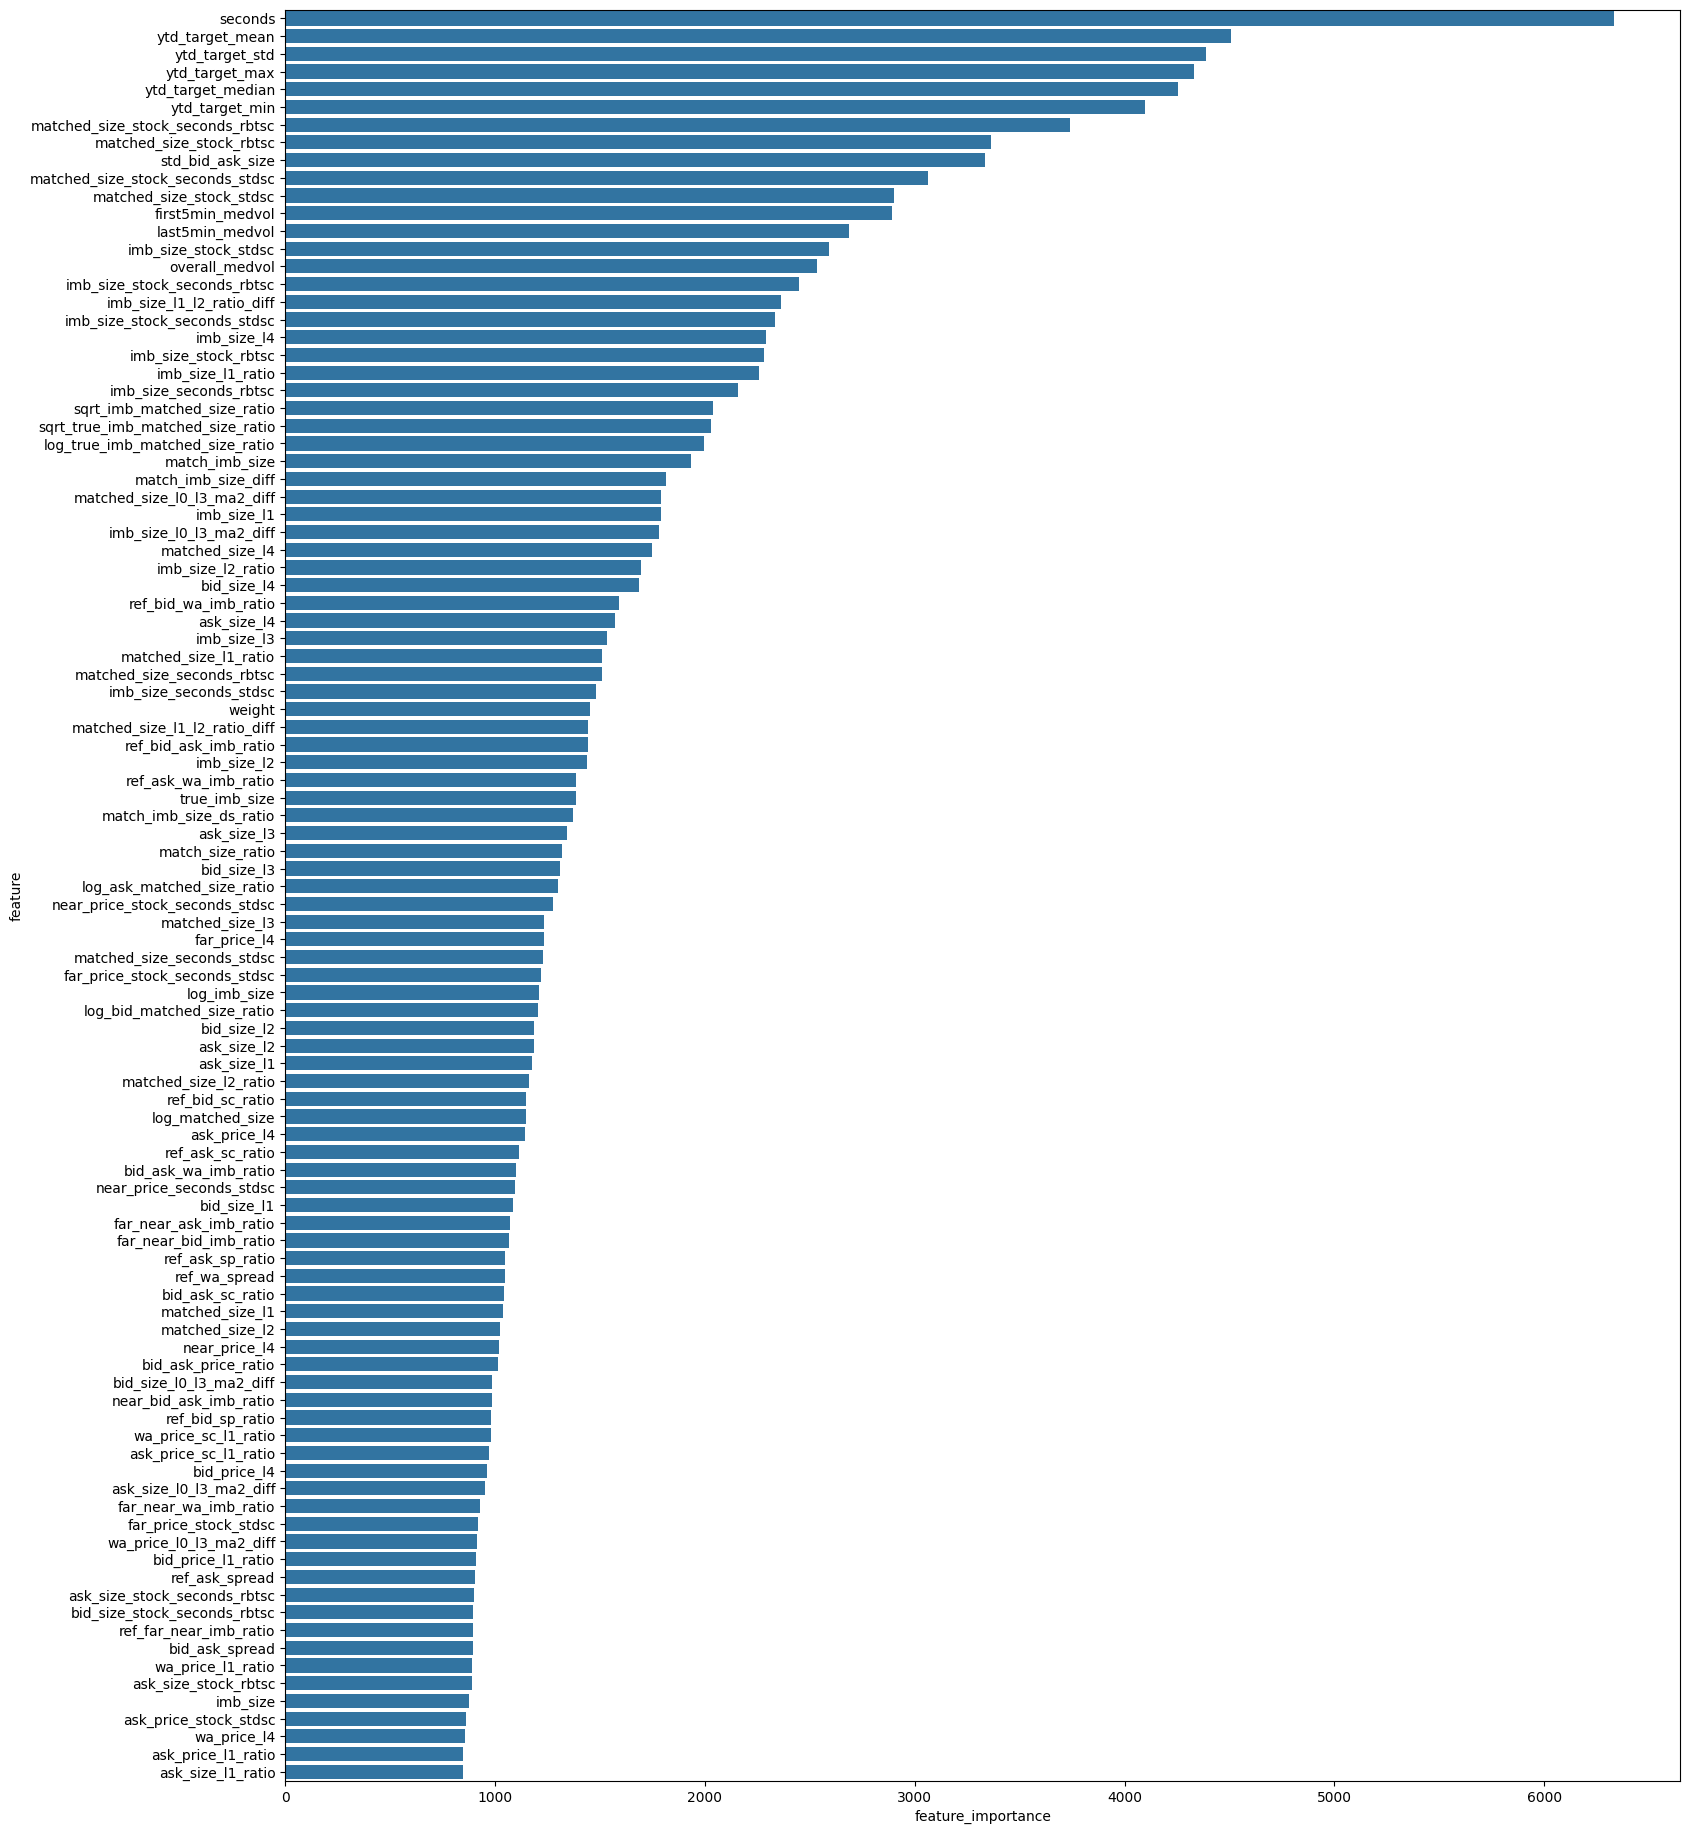

In [60]:
feature_imp_df = plot_feature_importance(
    features=model.feature_name(), importances=model.feature_importance(), return_df=True, limit=100, figsize=(18, 23)
)

In [206]:
%%time
feature_summary_df, feature_corr_df, linkage_matrix = get_feature_summary(bin_model, train, clustering_threshold=0.5)

15:02:19 Calculating Feature Correlation...
15:19:59 Forming Feature Clusters...
CPU times: user 8min 50s, sys: 5min 39s, total: 14min 29s
Wall time: 17min 40s


In [208]:
feature_summary_df

,feature,feature_importance,feature_importance_rank,clusters
0,seconds,7221,1,65
1,normalized_stock_date_target_max2_ma3_ma2_ratio,5819,2,67
2,normalized_stock_date_target_max_ma3_ma2_ratio,5725,3,74
3,normalized_stock_date_target_min_ma3_ma2_ratio,5699,4,68
4,normalized_stock_date_target_min2_ma3_ma2_ratio,5677,5,69
...,...,...,...,...
277,far_wa_sc_ratio,186,261,123
278,far_price_sc_l1_l2_ratio_diff,170,262,97
279,bid_ask_size_ratio,137,263,78
280,ref_far_sc_ratio,121,264,2


In [209]:
feature_summary_df.groupby("clusters")["feature"].count().sort_values(ascending=False)

clusters
133    9
123    9
4      7
121    6
132    6
      ..
60     1
25     1
35     1
102    1
67     1
Name: feature, Length: 133, dtype: int64

In [236]:
one_cluster_df = feature_summary_df.loc[feature_summary_df["clusters"] == 121]
one_cluster_df

,feature,feature_importance,feature_importance_rank,clusters
106,far_bid_ask_imb_ratio,1128,106,121
120,ref_far_bid_imb_ratio,990,119,121
123,ref_far_ask_imb_ratio,979,122,121
171,far_ask_wa_imb_ratio,776,164,121
174,far_bid_wa_imb_ratio,765,167,121
181,ref_far_wa_imb_ratio,741,172,121


In [237]:
features_to_drop = one_cluster_df["feature"].tolist()[1:]

In [245]:
features_to_drop

['ref_far_bid_imb_ratio',
 'ref_far_ask_imb_ratio',
 'far_ask_wa_imb_ratio',
 'far_bid_wa_imb_ratio',
 'ref_far_wa_imb_ratio']

In [60]:
feature_exp = pd.read_csv(r"../feature_experiment.csv")

In [62]:
i = 0

In [70]:
imp_list = []

In [71]:
for i in tqdm(range(50)):
    model = lgb.Booster(model_file=f"../models/lgbm/model{i}.txt")
    dict_ = dict(zip(model.feature_name(), model.feature_importance()))
    imp_list.append(dict_)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.76it/s]


In [73]:
feature_exp_imp = pd.DataFrame(imp_list)

In [80]:
feature_exp_imp["model_no"] = feature_exp["model_no"].astype(int)
feature_exp_imp["train_score"] = feature_exp["train_score"]
feature_exp_imp["va_score"] = feature_exp["va_score"]

In [79]:
feature_exp_imp = feature_exp_imp.reindex(columns=feature_exp.columns)

In [82]:
feature_exp_imp.to_csv(r"../feature_experiment_with_feature_importance.csv", index=False)

In [50]:
tlist, vlist = [], []
for col in feature_exp.columns[1:-2]:
    tlist.append(feature_exp.groupby(col)["train_score"].mean().diff().values[-1])
    vlist.append(feature_exp.groupby(col)["va_score"].mean().diff().values[-1])

In [51]:
result = pd.DataFrame(dict(feature=feature_exp.columns[1:-2], train_gain=tlist, val_gain=vlist))

In [52]:
result["train_gain_rank"] = result["train_gain"].rank(method="dense")
result["val_gain_rank"] = result["val_gain"].rank(method="dense")

In [53]:
potential_good_features = result.sort_values(by="val_gain_rank").iloc[:100].feature.tolist()

In [247]:
PRICE_MULTIPLIER = 10 # Factor to multiple the price col after taking the distance to 1
PRICE_POWER_FACTOR = 1/2 # Factor to transform the price col to bimodal distribution, the lower the further apart of the modes

In [248]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
for i in [3]:
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    
    tr = train.loc[train["date_id"].between(0, LAST_TRAIN_DATE)]
    # tr = train.loc[train["date_id"].between(0, 480)]
    cprint(f"Train shape {tr.shape}", color="yellow")
    train_data = lgb.Dataset(
        tr.drop(columns=target_column_list + cols_to_remove + features_to_drop, errors="ignore"), #.drop(columns=features_to_drop),
        tr["target"].values
    )
    del tr
    gc.collect()
    
    va = train.loc[train["date_id"].between(LAST_TRAIN_DATE + 1, 480)]
    valid_data = lgb.Dataset(
        va.drop(columns=target_column_list + cols_to_remove + features_to_drop, errors="ignore"), #.drop(columns=features_to_drop),
        va["target"].values,
        reference=train_data
    )
    
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data, valid_data
    gc.collect()
    
#     model_list.append(model)
    va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

    va_score = (va_pred - va["target"]).abs().mean()
    cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

17:26:05 Preparing Dataset...
Train shape (4577980, 288)
17:26:21 Training...
[100]	training's l1: 6.32011	valid_0's l1: 5.70649
[200]	training's l1: 6.27321	valid_0's l1: 5.69449
[300]	training's l1: 6.23598	valid_0's l1: 5.69143
[400]	training's l1: 6.20294	valid_0's l1: 5.69018
[500]	training's l1: 6.17411	valid_0's l1: 5.68992
[600]	training's l1: 6.14798	valid_0's l1: 5.69008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:23<00:00,  3.48it/s]

17:36:30 5.69009
CPU times: user 1h 18min 14s, sys: 5min 4s, total: 1h 23min 18s
Wall time: 10min 25s


In [106]:
# lgbm_model2 = lgb.Booster(model_file='../models/lgbm/lgbm_model2.txt')
# lgbm_model3 = lgb.Booster(model_file='../models/lgbm/lgbm_model3.txt')

In [87]:
va["lgbm_pred2"] = lgbm_inference_by_batch(lgbm_model2, va)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:32<00:00,  2.48it/s]


In [93]:
va["lgbm_pred3"] = lgbm_inference_by_batch(lgbm_model3, va)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:47<00:00,  1.71it/s]


In [85]:
# model.save_model('../models/lgbm/lgbm_model3.txt')

In [49]:
va["lgbm_pred"] = va_pred

In [52]:
va.shape[0], keras_va.shape[0]

(660000, 551954)

In [50]:
keras_va = pd.read_parquet("../keras_val.parquet")

In [88]:
va["lgbm_pred2"]

4577980   -0.415797
4577981    2.407354
4577982   -1.593276
4577983    0.793018
4577984    3.466511
             ...   
5237975   -2.477129
5237976   -1.954007
5237977    0.032771
5237978    1.310975
5237979   -3.378635
Name: lgbm_pred2, Length: 660000, dtype: float64

In [94]:
(va["lgbm_pred3"] - va["target"]).abs().mean()

5.529154709318304

In [95]:
(va["lgbm_pred2"] - va["target"]).abs().mean()

5.5705429153648245

In [97]:
# (va["keras_pred"] - va["target"]).abs().mean()

In [79]:
# va["ensemble_pred"] = np.where(
#     va["keras_pred"].isnull(), 
#     va["lgbm_pred"],
#     (0.2 * va["keras_pred"] + 0.8 * va["lgbm_pred"])
# )

In [103]:
va["ensemble_pred"] = (0.1 * va["lgbm_pred2"] + 0.9 * va["lgbm_pred3"])

In [104]:
(va["ensemble_pred"] - va["target"]).abs().mean()

5.532514844776527

In [58]:
va = va.merge(keras_va[["stock_id", "date_id", "seconds", "keras_pred"]], on=["stock_id", "date_id", "seconds"], how="left")

In [ ]:
(keras_va["lgbm_pred"] - keras_va["target"]).abs().mean()

In [ ]:
5.69353

In [72]:
# for k in np.arange(20, 100, 5):
#     cprint(f"k: {k}", color="green", end="\t")
#     cprint(
#         f"Val Score: {(pd.Series(va_pred).fillna(0).clip(-k, k) - va['target'].values).abs().mean():.5f}", 
#         color="blue"
#     )

In [79]:
(va_pred - va["target"]).abs().mean()

5.693534621170634

In [ ]:
# %%time
# X_tr = feat_eng(tr).drop(columns=target_column_list + cols_to_remove)
# X_va = feat_eng(va).drop(columns=target_column_list + cols_to_remove)
# y_tr = tr[FINAL_TARGET_COLUMN].values
# y_va = va[FINAL_TARGET_COLUMN].values

In [ ]:
# %%time
# model = lgb.LGBMRegressor(
#     learning_rate=0.018052307589575444, 
#     max_depth=9, 
#     n_estimators=700,
#     num_leaves=442, 
#     objective='mae', 
#     random_state=42,
#     reg_alpha=0.02216069565875271, 
#     reg_lambda=0.01223572246957101
# )
# model.fit(X_tr, y_tr)

In [ ]:
# %%time
# y_tr_pred = model.predict(X_tr)
# tr_pred_df = pd.DataFrame(dict(gt=tr["target"], pred=y_tr_pred, bid_size=tr["bid_size"], ask_size=tr["ask_size"]))
# tr_pred_df.dropna(subset=["gt"], inplace=True)

In [ ]:
# y_va_pred = model.predict(X_va)
# va_pred_df = pd.DataFrame(dict(gt=va["target"], pred=y_va_pred, bid_size=va["bid_size"], ask_size=va["ask_size"]))
# va_pred_df.dropna(subset=["gt"], inplace=True)
# print((zero_sum(va_pred_df["pred"], va_pred_df["bid_size"] + va_pred_df["ask_size"]) - va_pred_df["gt"]).abs().mean())

In [ ]:
# y_va_pred = model.predict(X_va)
# va_pred_df = pd.DataFrame(dict(gt=va["target"], pred=y_va_pred, bid_size=va["bid_size"], ask_size=va["ask_size"]))
# va_pred_df.dropna(subset=["gt"], inplace=True)
# print((zero_sum(va_pred_df["pred"], va_pred_df["bid_size"] + va_pred_df["ask_size"]) - va_pred_df["gt"]).abs().mean())

In [ ]:
# sns.scatterplot(x=tr["target"], y=y_tr_pred)
# plt.show()

In [ ]:
# (zero_sum(tr_pred_df["pred"], tr_pred_df["bid_size"] + tr_pred_df["ask_size"]) - tr_pred_df["gt"]).abs().mean()

In [ ]:
# (zero_sum(va_pred_df["pred"], va_pred_df["bid_size"] + va_pred_df["ask_size"]) - va_pred_df["gt"]).abs().mean()

In [ ]:
# column = "log_imbalance_temp"
# target_column = "hollow_target"
# sns.scatterplot(x=va[column], y=va[target_column])
# plt.show()
# va[[column, target_column]].corr()

In [ ]:
# va["imbalance_temp"] = (va["imbalance_size"] - va["imbalance_mean"]) / va["imbalance_std"] * va["imbalance_buy_sell_flag"]

In [ ]:
# train["log_imbalance_size"] = np.log1p(train["imbalance_size"])
# va["log_imbalance_size"] = np.log1p(va["imbalance_size"])

In [ ]:
# imbalance_central_tendency = train.groupby("stock_id")["log_imbalance_size"].agg(["median", "mean", "std"]).add_prefix("log_imbalance_")
# va.drop(columns=imbalance_central_tendency.columns, errors="ignore", inplace=True)
# va = va.merge(imbalance_central_tendency, left_on=["stock_id"], right_index=True, how="left")

In [ ]:
# va["log_imbalance_temp"] = va["log_imbalance_size"] / va["log_imbalance_std"]

In [ ]:
# plot_feature_importance(model.feature_name_, model.feature_importances_)

# Prepare Submission

In [47]:
import optiver2023

In [48]:
SUBMIT = False

In [49]:
if SUBMIT:
    env = optiver2023.make_env()
    iter_test = env.iter_test()
else:
    iter_test = joblib.load("/kaggle/input/optiver-test-data/iter_test_copy.pkl")

In [50]:
# Inference on whole dataset, by batch
def lgbm_inference_by_batch(model, data, batch_size=8192):
    score_list = []
    for i in tqdm(range(int(data.shape[0] / batch_size) + 1)):
        try:
            score_list.extend(model.predict(
                data[model.feature_name()].iloc[int(i * batch_size): int((i+1) * batch_size)], 
            ))
        except:
            print("Too Many Batch")
    return score_list

In [51]:
lgbm_model = lgb.Booster(model_file='/kaggle/input/optiver-lgbm-models/lgbm_model2.txt')

In [54]:
test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,row_id,order
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,478_0_0,0
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,478_0_1,1
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,478_0_2,2
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,478_0_3,3
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,478_0_4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,478,0,11075474.70,1,0.999672,11165016.52,NaN,NaN,0.999792,24960.00,1.000153,18310.60,1.0,478_0_195,195
196,196,478,0,1303523.55,1,0.999953,2280988.82,NaN,NaN,0.999953,4533.30,1.000206,19715.00,1.0,478_0_196,196
197,197,478,0,3920578.20,-1,1.000605,2969820.70,NaN,NaN,0.999650,5760.15,1.000318,5240.00,1.0,478_0_197,197
198,198,478,0,5074285.84,-1,1.000136,34865444.24,NaN,NaN,0.999894,74171.94,1.000136,95381.00,1.0,478_0_198,198


In [59]:
revealed_targets.groupby(["stock_id", "revealed_date_id"])["revealed_target"].describe()

,,count,mean,std,min,25%,50%,75%,max
stock_id,revealed_date_id,,,,,,,,
0,477,55.0,-1.736532,3.995226,-12.480021,-4.009902,-1.620054,1.245141,6.610155
1,477,55.0,-2.834667,6.917208,-20.099878,-5.914867,-0.249743,1.254678,7.640123
2,477,55.0,0.025966,9.563973,-14.389753,-5.804896,-1.839995,4.374981,27.610064
3,477,55.0,-0.940529,4.132701,-9.959936,-3.530085,-0.370145,0.964999,8.620024
4,477,55.0,0.487458,4.455853,-6.809831,-2.194941,-0.140071,2.444983,13.780594
...,...,...,...,...,...,...,...,...,...
195,477,55.0,1.95151,5.62217,-12.050271,-1.710057,2.510548,5.620122,15.920401
196,477,55.0,-2.73982,4.895452,-14.110208,-6.840229,-1.490116,0.734925,5.270243
197,477,55.0,-2.646381,6.36294,-16.149879,-7.130206,-1.320243,1.564622,11.310577


In [52]:
%%time
N = 3
temp_list = []
test_list = []
targets_list = []
sample_pred_list = []
for (test, revealed_targets, sample_prediction) in iter_test:
    test["order"] = range(test.shape[0])
    
    # Reset list if next day (seconds == 0) is seen
    second = test["seconds_in_bucket"].values[0]
    if second == 0:
        temp_list = []
    elif len(temp_list) == N:
        # If the list equals max_elem dataframes, remove the first dataframe then only append
        temp_list.pop(0)
        
    temp_list.append(test)
    
    # Concatenate the dataframes so that we can calculate lag features
    a = pd.concat(temp_list, ignore_index=True)
    
    # Clean & Preprocess, then apply feature engineering
    a = clean_df(a)
    a = clip_df(a, price_clippers=price_clippers, volume_clippers=volume_clippers)
    a, _ = feature_engineering(a, around_one_price_cols=around_one_price_cols, verbose=False)
    
    # Retrieve only the last 10-seconds row, since they are the 主角 for this batch
    a = a.loc[a["seconds"] == second].sort_values(by="order").drop(columns="order").reset_index(drop=True)

    # Prediction using our model(s)
    sample_prediction['target'] = lgbm_inference_by_batch(lgbm_model, data=a)
    sample_prediction['target'] = sample_prediction['target'].fillna(0).clip(-50, 50)
    
#     # Adjust our prediction using this function, actually I don't know what is its function
#     sample_prediction['target'] = zero_sum(
#         sample_prediction['target'], 
#         a['bid_size'] + a['ask_size']
#     ).values
    sample_pred_list.append(sample_prediction)
    
    if SUBMIT:
        # Need to call this env.predict to update / submit our prediction
        env.predict(sample_prediction)
        
    break

100%|██████████| 1/1 [00:00<00:00, 19.31it/s]

CPU times: user 363 ms, sys: 2.57 ms, total: 365 ms
Wall time: 324 ms


In [ ]:
if len(sample_pred_list) == 165:
    raw_train = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/train.csv')
    result = pd.concat(sample_pred_list)
    result = result.merge(raw_train[["row_id", "target", "bid_size"]], on="row_id", how="left")
    print((result["target_x"] - result["target_y"]).abs().mean())

## Get Feature Summary & Plot Feature Cluster

In [38]:
# def plot_clustering_dendogram(linkage_matrix, distance_df):
#     fig, ax = plt.subplots(figsize=(19, 25))
#     dendrogram = sch.dendrogram(linkage_matrix, labels=distance_df.index, orientation='right')
#     plt.xlabel('Correlation Distance')
#     plt.title('Hierarchical Clustering Dendrogram')
#     plt.show()

In [39]:
# %%time
# feature_summary, feature_corr_df, feature_linkage_matrix = get_feature_summary(lgbm_model, train.sample(523798), clustering_threshold=1.5)
# plot_clustering_dendogram(feature_linkage_matrix, feature_corr_df)

# Previous Temporal Features Calculation

In [34]:
%%time
LOOK_BACK_DATE = 30
daily_global_target_stats = {}
for stats in ["mean", "median", "min", "max", "std"]:
    daily_global_target_stats[f"prev_date_global_target_{stats}"] = train.groupby("date_id")["target"].agg(stats).apply(
        lambda x: [x] # Convert the target mean into a list with just one item so that we can use cumsum to concatenate the daily target mean
    ).cumsum().apply(
        lambda x: x[::-1][:LOOK_BACK_DATE] # Reverse the list so that the most recent one is at the start, then truncated by only taking the first N most recent target
    ).shift(1) # Shift to avoid data leakage
    
daily_global_target_stats = pd.DataFrame(daily_global_target_stats).reset_index()
daily_global_target_stats

CPU times: user 284 ms, sys: 39.7 ms, total: 323 ms
Wall time: 322 ms


,date_id,prev_date_global_target_mean,prev_date_global_target_median,prev_date_global_target_min,prev_date_global_target_max,prev_date_global_target_std
0,0,None,None,None,None,None
1,1,[-0.5574731230735779],[-0.5298852920532227],[-60.200096130371094],[85.19053649902344],[8.168275833129883]
2,2,"[-0.2828964293003082, -0.5574731230735779]","[-0.2598762512207031, -0.5298852920532227]","[-130.82980346679688, -60.200096130371094]","[98.84953308105469, 85.19053649902344]","[9.041149139404297, 8.168275833129883]"
3,3,"[-0.1406160593032837, -0.2828964293003082, -0....","[-0.12993812561035156, -0.2598762512207031, -0...","[-66.77985382080078, -130.82980346679688, -60....","[96.4701156616211, 98.84953308105469, 85.19053...","[9.153743743896484, 9.041149139404297, 8.16827..."
4,4,"[-0.026630481705069542, -0.1406160593032837, -...","[-0.14007091522216797, -0.12993812561035156, -...","[-100.1900405883789, -66.77985382080078, -130....","[73.64988708496094, 96.4701156616211, 98.84953...","[8.285481452941895, 9.153743743896484, 9.04114..."
...,...,...,...,...,...,...
476,476,"[0.07772993296384811, -0.39757010340690613, -0...","[0.30994415283203125, -0.050067901611328125, -...","[-138.63026428222656, -133.70989990234375, -56...","[111.83976745605469, 268.87060546875, 51.61046...","[8.591558456420898, 13.051695823669434, 6.7846..."
477,477,"[-0.3104068636894226, 0.07772993296384811, -0....","[-0.209808349609375, 0.30994415283203125, -0.0...","[-64.12029266357422, -138.63026428222656, -133...","[61.78974914550781, 111.83976745605469, 268.87...","[7.446479320526123, 8.591558456420898, 13.0516..."
478,478,"[-0.1384873241186142, -0.3104068636894226, 0.0...","[-0.29981136322021484, -0.209808349609375, 0.3...","[-90.789794921875, -64.12029266357422, -138.63...","[71.05946350097656, 61.78974914550781, 111.839...","[7.664499759674072, 7.446479320526123, 8.59155..."
479,479,"[0.02312465012073517, -0.1384873241186142, -0....","[-0.029802322387695312, -0.29981136322021484, ...","[-89.76995849609375, -90.789794921875, -64.120...","[77.12960052490234, 71.05946350097656, 61.7897...","[7.532643795013428, 7.664499759674072, 7.44647..."


In [60]:
# daily_global_target_stats.to_parquet("../data/optiver-support-data/daily_global_target_stats.parquet")

In [42]:
%%time
LOOK_BACK_DATE = 30
train = train.sort_values(by=["stock_id", "date_id"]).reset_index(drop=True)
daily_stock_target_stats = {}
for stats in ["mean", "median", "min", "max", "std"]:
    daily_stock_target_stats[f"prev_date_stock_target_{stats}"] = train.groupby(["stock_id", "date_id"])["target"].agg(stats).apply(
        lambda x: [x] # Convert the target mean into a list with just one item so that we can use cumsum to concatenate the daily target mean
    ).cumsum().progress_apply(
        lambda x: x[::-1][:LOOK_BACK_DATE] # Reverse the list so that the most recent one is at the start, then truncated by only taking the first N most recent target
    ).shift(1) # Shift to avoid data leakage
    
daily_stock_target_stats = pd.DataFrame(daily_stock_target_stats).reset_index()
daily_stock_target_stats

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95236/95236 [01:53<00:00, 839.66it/s]


CPU times: user 3min 24s, sys: 3min 32s, total: 6min 56s
Wall time: 11min 43s


,stock_id,date_id,prev_date_stock_target_mean,prev_date_stock_target_median,prev_date_stock_target_min,prev_date_stock_target_max,prev_date_stock_target_std
0,0,0,None,None,None,None,None
1,0,1,[-0.7345351576805115],[0.020265579223632812],[-10.679960250854492],[9.759664535522461],[4.185722827911377]
2,0,2,"[0.3289417624473572, -0.7345351576805115]","[1.0097026824951172, 0.020265579223632812]","[-14.08994197845459, -10.679960250854492]","[6.7996978759765625, 9.759664535522461]","[4.007033824920654, 4.185722827911377]"
3,0,3,"[-0.3267093300819397, 0.3289417624473572, -0.7...","[0.040531158447265625, 1.0097026824951172, 0.0...","[-15.569925308227539, -14.08994197845459, -10....","[8.629560470581055, 6.7996978759765625, 9.7596...","[5.143941879272461, 4.007033824920654, 4.18572..."
4,0,4,"[-3.2250990867614746, -0.3267093300819397, 0.3...","[-3.8701295852661133, 0.040531158447265625, 1....","[-17.899871826171875, -15.569925308227539, -14...","[8.759498596191406, 8.629560470581055, 6.79969...","[5.174627780914307, 5.143941879272461, 4.00703..."
...,...,...,...,...,...,...,...
95231,199,476,"[-0.3231005370616913, 0.9247280955314636, -1.9...","[0.30040740966796875, 1.519918441772461, -2.58...","[-12.249946594238281, -19.02997589111328, -12....","[11.14964485168457, 14.35995101928711, 6.09040...","[5.55213737487793, 6.242770195007324, 4.272174..."
95232,199,477,"[0.9665055871009827, -0.3231005370616913, 0.92...","[0.7402896881103516, 0.30040740966796875, 1.51...","[-10.579824447631836, -12.249946594238281, -19...","[12.860298156738281, 11.14964485168457, 14.359...","[5.772026538848877, 5.55213737487793, 6.242770..."
95233,199,478,"[-4.2260236740112305, 0.9665055871009827, -0.3...","[-4.870295524597168, 0.7402896881103516, 0.300...","[-15.050172805786133, -10.579824447631836, -12...","[3.7097930908203125, 12.860298156738281, 11.14...","[4.536808013916016, 5.772026538848877, 5.55213..."
95234,199,479,"[1.3231254816055298, -4.2260236740112305, 0.96...","[1.920461654663086, -4.870295524597168, 0.7402...","[-11.900067329406738, -15.050172805786133, -10...","[13.500452041625977, 3.7097930908203125, 12.86...","[5.631494998931885, 4.536808013916016, 5.77202..."


In [45]:
# daily_stock_target_stats.to_parquet("../data/optiver-support-data/daily_stock_target_stats.parquet")

In [96]:
daily_target_stats = daily_stock_target_stats.merge(daily_global_target_stats, on="date_id", how="left")
daily_target_stats = daily_target_stats.dropna()

In [104]:
for col in daily_target_stats.columns[2:]:
    daily_target_stats[col] = daily_target_stats[col].apply(np.array)

In [109]:
daily_target_stats["prev_date_stock_target_mean"].iloc[3] - daily_target_stats["prev_date_global_target_mean"].iloc[3]

array([-3.19846861, -0.18609327,  0.61183819, -0.17706203])

In [ ]:
def pr(row):
    try:
        row.prev_date_stock_target_mean - row.prev_date_global_target_mean

In [116]:
daily_target_stats.loc[daily_target_stats["prev_date_stock_target_mean"].str.len() != daily_target_stats["prev_date_global_target_mean"].str.len()]

,stock_id,date_id,prev_date_stock_target_mean,prev_date_stock_target_median,prev_date_stock_target_min,prev_date_stock_target_max,prev_date_stock_target_std,prev_date_global_target_mean,prev_date_global_target_median,prev_date_global_target_min,prev_date_global_target_max,prev_date_global_target_std
482,1,1,"[1.1445717811584473, 0.5915165543556213, -1.39...","[-1.5497207641601562, 0.6496906280517578, -0.1...","[-10.449886322021484, -10.420083999633789, -11...","[28.949975967407227, 8.510351181030273, 6.4694...","[8.197073936462402, 3.9718258380889893, 4.3429...",[-0.5574731230735779],[-0.5298852920532227],[-60.200096130371094],[85.19053649902344],[8.168275833129883]
483,1,2,"[1.6627745628356934, 1.1445717811584473, 0.591...","[1.4102458953857422, -1.5497207641601562, 0.64...","[-11.969804763793945, -10.449886322021484, -10...","[16.280412673950195, 28.949975967407227, 8.510...","[6.597947597503662, 8.197073936462402, 3.97182...","[-0.2828964293003082, -0.5574731230735779]","[-0.2598762512207031, -0.5298852920532227]","[-130.82980346679688, -60.200096130371094]","[98.84953308105469, 85.19053649902344]","[9.041149139404297, 8.168275833129883]"
484,1,3,"[0.07706336677074432, 1.6627745628356934, 1.14...","[1.0395050048828125, 1.4102458953857422, -1.54...","[-24.639965057373047, -11.969804763793945, -10...","[34.1796875, 16.280412673950195, 28.9499759674...","[12.275678634643555, 6.597947597503662, 8.1970...","[-0.1406160593032837, -0.2828964293003082, -0....","[-0.12993812561035156, -0.2598762512207031, -0...","[-66.77985382080078, -130.82980346679688, -60....","[96.4701156616211, 98.84953308105469, 85.19053...","[9.153743743896484, 9.041149139404297, 8.16827..."
485,1,4,"[1.6297861337661743, 0.07706336677074432, 1.66...","[1.7201900482177734, 1.0395050048828125, 1.410...","[-16.07000732421875, -24.639965057373047, -11....","[17.080307006835938, 34.1796875, 16.2804126739...","[8.477258682250977, 12.275678634643555, 6.5979...","[-0.026630481705069542, -0.1406160593032837, -...","[-0.14007091522216797, -0.12993812561035156, -...","[-100.1900405883789, -66.77985382080078, -130....","[73.64988708496094, 96.4701156616211, 98.84953...","[8.285481452941895, 9.153743743896484, 9.04114..."
486,1,5,"[-0.2847476303577423, 1.6297861337661743, 0.07...","[-2.2101402282714844, 1.7201900482177734, 1.03...","[-14.380216598510742, -16.07000732421875, -24....","[19.919872283935547, 17.080307006835938, 34.17...","[9.826698303222656, 8.477258682250977, 12.2756...","[-0.11555680632591248, -0.026630481705069542, ...","[0.059604644775390625, -0.14007091522216797, -...","[-81.4300765991211, -100.1900405883789, -66.77...","[64.69010925292969, 73.64988708496094, 96.4701...","[8.244714736938477, 8.285481452941895, 9.15374..."
...,...,...,...,...,...,...,...,...,...,...,...,...
94387,198,25,"[-0.48817288875579834, 0.39641425013542175, 1....","[-1.0901689529418945, 1.1301040649414062, 1.46...","[-6.369948387145996, -11.069774627685547, -7.4...","[6.510019302368164, 4.71949577331543, 7.890462...","[2.9460933208465576, 3.5450358390808105, 3.744...","[-0.43549665808677673, -0.12510010600090027, 0...","[-0.5799531936645508, 0.050067901611328125, 0....","[-69.19026184082031, -43.9101448059082, -53.33...","[44.46983337402344, 64.17990112304688, 53.0803...","[6.154864311218262, 7.035421848297119, 6.70116..."
94388,198,26,"[-0.2252296805381775, -0.48817288875579834, 0....","[-1.0597705841064453, -1.0901689529418945, 1.1...","[-10.780096054077148, -6.369948387145996, -11....","[17.420053482055664, 6.510019302368164, 4.7194...","[6.7027130126953125, 2.9460933208465576, 3.545...","[-0.1317184865474701, -0.43549665808677673, -0...","[0.08940696716308594, -0.5799531936645508, 0.0...","[-82.03983306884766, -69.19026184082031, -43.9...","[40.88043975830078, 44.46983337402344, 64.1799...","[7.143494606018066, 6.154864311218262, 7.03542..."
94389,198,27,"[-1.9321658611297607, -0.2252296805381775, -0....","[-2.250075340270996, -1.0597705841064453, -1.0...","[-11.039972305297852

In [56]:
%%time
new_feature_list = []
for i in [3, 5, 7, 9]:
    for stats in ["mean", "median", "min", "max", "std"]:
        new_feature_name = f"target_{stats}_ma{i}"
        daily_target_stats[new_feature_name] = daily_target_stats[f"prev_date_stock_target_{stats}"].apply(lambda x: np.mean(x[:i]) if x is not None else np.nan)
        new_feature_list.append(new_feature_name)

CPU times: user 5.39 s, sys: 46.4 ms, total: 5.43 s
Wall time: 5.43 s


In [62]:
%%time
train = train.merge(
    daily_target_stats[["stock_id", "date_id"] + new_feature_list],
    on=["stock_id", "date_id"],
    how="left"
)

CPU times: user 898 ms, sys: 3.64 s, total: 4.53 s
Wall time: 7.6 s


In [63]:
# fig, ax = plt.subplots(figsize=(18, 7))
# ax.plot(range(480 - LOOK_BACK_DATE, 480), daily_global_target_stats["prev_date_target_mean"][480], label="target_mean")
# plt.xlabel("Date ID")
# plt.title("Previous Date Average Target")
# plt.show()

## Feature Experiment

In [ ]:
for i in tqdm(range(15, 50)):
    model = lgb.Booster(model_file=f'../models/lgbm/model{i}.txt')
    result = pd.concat([result, pd.DataFrame([{k: 1 for k in model.feature_name()}])], ignore_index=True)
    result.iloc[i] = result.iloc[i].fillna(0)
    va_pred = lgbm_inference_by_batch(model, va, verbose=0)
    train_pred = lgbm_inference_by_batch(model, tr, verbose=0)
    
    train_score = (tr["target"] - train_pred).abs().mean()
    va_score = (va["target"] - va_pred).abs().mean()
    
    result.loc[i, "train_score"] = train_score
    result.loc[i, "va_score"] = va_score
    result.loc[i, "model_no"] = i
# result.to_csv("../feature_experiment.csv", index=False)

## Get Rolling Columns

In [411]:
# %%time
# master_rolling_features = pd.read_parquet(f"{DATA_DIR}/optiver-train-data/rolling_targets.parquet")

In [412]:
# master_df = master_df.merge(
#     master_rolling_features, on=META_COLUMNS, how="left"
# )

In [ ]:
def get_rolling_columns(df, base_column, window_size=18, group_column=["stock_id", "date_id"], lag=0):
    df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    column_name = f"{base_column}_l{lag}"
    if lag > 0:
        df[column_name] = df.groupby(group_column)[base_column].shift(lag)
    else:
        df[column_name] = df[base_column]
    
    temp_list = []
    for i, window in tqdm(enumerate(df.groupby(group_column).rolling(window=window_size))):
        array = window[column_name].to_numpy()
        if window_size > len(array):
            array = np.pad(array, (window_size - len(array), 0), constant_values=np.nan)
        temp_list.append(array)
    
    if lag > 0:
        df[f"{base_column}_w{window_size}_l{lag}"] = temp_list
    else:
        df[f"{base_column}_w{window_size}"] = temp_list
    df.drop(columns=column_name, errors="ignore", inplace=True)
    return df

In [417]:
# for base_col in base_columns:
#     cprint(f'Doing {base_col}', color="blue")
#     master_df = get_rolling_columns(master_df, base_column=base_col, window_size=18, group_column=["stock_id", "date_id"], lag=0)
    
#     if base_col.endswith("_size"):
#         master_df[f"log_{base_col}"] = my_log(master_df[base_col])
#         master_df = get_rolling_columns(master_df, base_column=f"log_{base_col}", window_size=18, group_column=["stock_id", "date_id"], lag=0)
    
#     if base_col.endswith("_price"):
#         master_df[f"c_{base_col}"] = (master_df[base_col] - 1)
#         master_df = get_rolling_columns(master_df, base_column=f"c_{base_col}", window_size=18, group_column=["stock_id", "date_id"], lag=0)

In [418]:
# for target_col in ["target", "is_positive_target", "is_mild_target"]:
#     cprint(f'Doing {target_col}', color="blue")
#     master_df = get_rolling_columns(master_df, base_column=target_col, window_size=18, group_column=["stock_id", "date_id"], lag=6)

In [419]:
# for col in get_cols(master_df, endswith="w18", excludes="c_"):
#     cprint(f"Fit regression line for {col}...", color="blue")
#     master_df[[f"{col}_gradient", f"{col}_intercept"]] = master_df[col].progress_apply(
#         lambda r: np.polyfit(range(len(r)), (r - np.mean(r)) / np.std(r), 1)
#     ).apply(pd.Series).values

In [420]:
# master_df[META_COLUMNS + get_cols(master_df, endswith=["_w18_l6", "_w18"])].to_parquet(f"{DATA_DIR}/optiver-train-data/rolling_targets.parquet")

In [ ]:
# master_df["target_l6_w12_mean"] = master_df["target_l6_w12"].progress_apply(np.mean)
# master_df["target_l6_w12_median"] = master_df["target_l6_w12"].progress_apply(np.median)
# master_df["target_l6_w12_std"] = master_df["target_l6_w12"].progress_apply(np.std)

# Group By Apa2

## Groupby Stock ID

In [386]:
stock_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_level_stats_.parquet")
stock_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_level_stats.parquet")

In [389]:
for col in get_cols(stock_level_stats, "size"):
    stock_level_stats_[col] = my_log(stock_level_stats_[col])
    stock_level_stats[col] = my_log(stock_level_stats[col])

In [390]:
# stock_level_stats_ = stock_level_stats_.reset_index()
# stock_level_stats = stock_level_stats.reset_index()

In [391]:
base_columns

['ask_price',
 'ask_size',
 'bid_price',
 'bid_size',
 'far_price',
 'imb_size',
 'matched_size',
 'near_price',
 'ref_price',
 'wa_price']

In [392]:
train = scale_base_columns(
    train, 
    _level_stats_df=stock_level_stats_, 
    level_col="stock", 
    join_col="stock_id", 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=stock_level_stats, 
    level_col="stock", 
    join_col="stock_id", 
    base_columns=base_columns
)

## Groupby Seconds

In [31]:
seconds_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/seconds_level_stats_.parquet")
seconds_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/seconds_level_stats.parquet")

In [32]:
for col in get_cols(seconds_level_stats, "size"):
    seconds_level_stats_[col] = my_log(seconds_level_stats_[col])
    seconds_level_stats[col] = my_log(seconds_level_stats[col])

In [33]:
train = scale_base_columns(
    train, 
    _level_stats_df=seconds_level_stats_, 
    level_col="seconds", 
    join_col="seconds", 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=seconds_level_stats, 
    level_col="seconds", 
    join_col="seconds", 
    base_columns=base_columns
)

## Groupby Date

In [34]:
date_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/date_level_stats_.parquet")
date_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/date_level_stats.parquet")

In [35]:
for col in get_cols(date_level_stats, "size"):
    date_level_stats_[col] = my_log(date_level_stats_[col])
    date_level_stats[col] = my_log(date_level_stats[col])

In [36]:
train = scale_base_columns(
    train, 
    _level_stats_df=date_level_stats_, 
    level_col="date", 
    join_col="date_id", 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=date_level_stats, 
    level_col="date", 
    join_col="date_id", 
    base_columns=base_columns
)

## Groupby Stock Date

In [37]:
stock_date_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_date_level_stats_.parquet")
stock_date_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_date_level_stats.parquet")

In [38]:
for col in get_cols(stock_date_level_stats, "size"):
    stock_date_level_stats_[col] = my_log(stock_date_level_stats_[col])
    stock_date_level_stats[col] = my_log(stock_date_level_stats[col])

In [39]:
train = scale_base_columns(
    train, 
    _level_stats_df=stock_date_level_stats_, 
    level_col="stock_date", 
    join_col=["stock_id", "date_id"], 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=stock_date_level_stats, 
    level_col="stock_date", 
    join_col=["stock_id", "date_id"], 
    base_columns=base_columns
)

## Groupby Stock Seconds

In [40]:
stock_seconds_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_seconds_level_stats_.parquet")
stock_seconds_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_seconds_level_stats.parquet")

In [41]:
for col in get_cols(stock_seconds_level_stats, "size"):
    stock_seconds_level_stats_[col] = my_log(stock_seconds_level_stats_[col])
    stock_seconds_level_stats[col] = my_log(stock_seconds_level_stats[col])

In [42]:
train = scale_base_columns(
    train, 
    _level_stats_df=stock_seconds_level_stats_, 
    level_col="stock_seconds", 
    join_col=["stock_id", "seconds"], 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=stock_seconds_level_stats, 
    level_col="stock_seconds", 
    join_col=["stock_id", "seconds"], 
    base_columns=base_columns
)

In [43]:
psi_list = []
for feature in get_cols(val, contains=["price", "val"]):
    psi_ = calculate_psi(train[feature].clip(1e6, -1e6).dropna(), val[feature].clip(1e6, -1e6).dropna())
    if psi_ > 0.2:
        cprint(f"PSI for {feature}: {psi_:.4f}", color="red")
    elif psi_ > 0.1:
        cprint(f"PSI for {feature}: {psi_:.4f}", color="yellow")
    else:
        cprint(f"PSI for {feature}: {psi_:.4f}", color="blue")
    psi_list.append(psi_)

PSI for ref_price: 0.1476
PSI for far_price: 0.1782
PSI for near_price: 0.0903
PSI for bid_price: 0.1442
PSI for ask_price: 0.1513
PSI for wa_price: 0.1102
PSI for ask_price_stock_rbtsc: 0.1699
PSI for ask_price_stock_stdsc: 0.1738
PSI for bid_price_stock_rbtsc: 0.1659
PSI for bid_price_stock_stdsc: 0.1719
PSI for far_price_stock_rbtsc: 0.1446
PSI for far_price_stock_stdsc: 0.1118
PSI for near_price_stock_rbtsc: 0.1232
PSI for near_price_stock_stdsc: 0.0930
PSI for ref_price_stock_rbtsc: 0.1678
PSI for ref_price_stock_stdsc: 0.1770
PSI for wa_price_stock_rbtsc: 0.1764
PSI for wa_price_stock_stdsc: 0.1840
PSI for ask_price_seconds_rbtsc: 0.1572
PSI for ask_price_seconds_stdsc: 0.1598
PSI for bid_price_seconds_rbtsc: 0.1399
PSI for bid_price_seconds_stdsc: 0.1514
PSI for far_price_seconds_rbtsc: 0.1149
PSI for far_price_seconds_stdsc: 0.1127
PSI for near_price_seconds_rbtsc: 0.0771
PSI for near_price_seconds_stdsc: 0.0929
PSI for ref_price_seconds_rbtsc: 0.1496
PSI for ref_price_seconds_

In [44]:
train = pd.concat([train, val], ignore_index=True)

In [45]:
# (train.isnull().sum() / train.shape[0]).sort_values()[-30:]

In [46]:
# price_and_vol_columns = get_cols(train, contains=["_price", "_size"], excludes=["scaled"])
# base_col_stock_avg_ref = train.groupby("stock_id")[price_and_vol_columns].mean().add_suffix("_mean")
# base_col_stock_std_ref = train.groupby("stock_id")[price_and_vol_columns].std().add_suffix("_std")
# base_col_date_avg_ref = train.groupby("date_id")[price_and_vol_columns].mean().add_suffix("_mean")
# base_col_date_std_ref = train.groupby("date_id")[price_and_vol_columns].std().add_suffix("_std")

# def scale(df):
#     # Get the base price and base volume columns (base means it is raw or raw after transformed)
#     price_and_vol_columns = get_cols(df, contains=["_price", "_size"], excludes=["scaled"])
    
#     # Merge the per-stock base columns avg and std reference prepared before-hand
#     df = df.merge(base_col_stock_avg_ref, on=["stock_id"], how="left")
#     df = df.merge(base_col_stock_std_ref, on=["stock_id"], how="left")
    
#     # For each of the base column, standardized it using the stock ID mean and stock ID std
#     for col in tqdm(price_and_vol_columns):
#         df["sc_stock_" + col] = (df[col] - df[col + "_mean"]) / df[col + "_std"]
        
#     # Remove the redundant avg & std reference columns
#     df.drop(columns=list(base_col_stock_avg_ref) + list(base_col_stock_std_ref), errors="ignore", inplace=True)
    
#     # Merge the per-date base columns avg and std reference prepared before-hand
#     df = df.merge(base_col_date_avg_ref, on=["date_id"], how="left")
#     df = df.merge(base_col_date_std_ref, on=["date_id"], how="left")
    
#     # For each of the base column, standardized it using the date ID mean and date ID std
#     for col in tqdm(price_and_vol_columns):
#         df["sc_date_" + col] = (df[col] - df[col + "_mean"]) / df[col + "_std"]
        
#     # Remove the redundant avg & std reference columns
#     df.drop(columns=list(base_col_date_avg_ref) + list(base_col_date_std_ref), errors="ignore", inplace=True)
    
#     return df

In [47]:
# %%time
# train = scale(train)